# Predicting MNIST digits with a CNN

The architecture of the network we will implement is shown below. The inputs are $28\times 28$ greyscale images. We put the images through a convolutional layer with kernel size $5\times 5$ and $32$ output feature maps, followed by a max-pooling layer with kernel size $2\times 2$. Then, we add another convolutional layer with kernel size $5\times 5$, this time with $64$ output feature maps, followed by another max-pooling layer with kernel size $2\times 2$. At this point, we flatten the features, and we implement a fully-connected layer with $1024$ nodes followed by a final fully-connected layer with $10$ nodes. 

Suppose there are $N$ instances in the training set. Then the dimensions of the tensors in each layer are as follows:

 - Input: $[N\times 28\times 28\times 1]$
 - Conv1: $[N\times 28\times 28\times 32]$
 - Pooling1: $[N\times 14\times 14\times 32]$
 - Conv2: $[N\times 14\times 14\times 64]$
 - Pooling2: $[N\times 7\times 7\times 64]$
 - FC1: $[N\times 1024]$
 - FC2: $[N\times 10]$
 
Note that we use `stride=1` in the convolutional layers so that the input dimensions are preserved in the subsequent feature maps.

We will implement this CNN using the `Sequential` class in the `torch.nn` module of PyTorch.

In [2]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import Subset

#load in MNIST data
image_path = './'
transform = transforms.ToTensor()
mnist_train = torchvision.datasets.MNIST(root=image_path, train=True, transform=transform, download=False)
mnist_test = torchvision.datasets.MNIST(root=image_path, train=False, transform=transform, download=False)

#create validation set
mnist_valid = Subset(mnist_train, torch.arange(10000))
mnist_train = Subset(mnist_train, torch.arange(10000, len(mnist_train)))

Above, we loaded in the data and set aside the first $10000$ training examples for validation. Now, we will construct two `DataLoader` objects to generate batches of $64$ images for both the training set and the validation set.

In [5]:
from torch.utils.data import DataLoader

#create DataLoaders for training set and validation set
batch_size = 64
torch.manual_seed(1) #set seed for reproducibility
train_dl = DataLoader(mnist_train, batch_size, shuffle=True)
valid_dl = DataLoader(mnist_valid, batch_size, shuffle=True)

Next, we will use the `Sequential` class to begin constructing the CNN architecure by adding the convolution and pooling layers.

In [8]:
import torch.nn as nn

#create model
model = nn.Sequential()

#add first convolutional layer with ReLU activation
model.add_module(
    'conv1',
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding=2)
)
model.add_module('relu1', nn.ReLU())

#add first pooling layer
model.add_module('pool1', nn.MaxPool2d(kernel_size=2))

#add second convolutional layer with ReLU activation
model.add_module(
    'conv2',
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2)
)
model.add_module('relu2', nn.ReLU())

#add second pooling layer
model.add_module('pool2', nn.MaxPool2d(kernel_size=2))

The spatial dimension of the output feature map is calculated by
$$
o = \left\lfloor\frac{n+2p-m}{s}\right\rfloor+1,
$$
where $o$ is the spatial dimension of the output feature map, $n$ is the spatial dimension of the input feature map, $p$ is the padding, $m$ is the kernel size, and $s$ is the stride length. We can use this to find the size of the feature maps after the input images have passed through the above layers in order to determine the input dimensions for the first fully-connected layer after flattening the features. However, rather than calculating the size of the feature maps manually, we can do the following:

In [11]:
#add Flatten layer to the CNN architecture
model.add_module('flatten', nn.Flatten())

#find dimensions after flattening, assuming N=10 training examples
x = torch.ones((10, 1, 28, 28))
model(x).shape

torch.Size([10, 3136])

From the above, we see that the input dimension for the first fully-connected layer is $3136$. Below, we add the two fully-connected layers with a droput layer in between for regularization.

In [13]:
#add first fully-connected layer with ReLU activation
model.add_module('fc1', nn.Linear(3136, 1024))
model.add_module('relu3', nn.ReLU())

#add dropout layer with probability 0.5
model.add_module('dropout', nn.Dropout(p=0.5))

#add final fully-connected layer
model.add_module('fc2', nn.Linear(1024, 10))

Now, we will set up the `CrossEntropyLoss` function, which means that we don't need to explicitly add the softmax function as a layer after the output layer above as it is already used internally inside PyTorch's `CrossEntropyLoss` implementation. We also implement the Adam optimizer. Finally, we define the training function for the model.

In [24]:
#define cross-entropy loss function
loss_fn = nn.CrossEntropyLoss()

#define Adam optimizer with learning rate 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#define train function
def train(model, num_epochs, train_dl, valid_dl):
    #track training and validation loss and accuracy
    loss_hist_train = [0] * num_epochs
    acc_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    acc_hist_valid = [0] * num_epochs
    
    #training loop
    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_dl:
            #generate predictions
            pred = model(x_batch)
            
            #calculate loss
            loss = loss_fn(pred, y_batch)
            
            #compute gradients
            loss.backward()
            
            #update parameters using gradients
            optimizer.step()
            
            #reset the gradients to zero
            optimizer.zero_grad()
            
            #add up the training loss and accuracy for each batch
            loss_hist_train[epoch] += loss.item() * y_batch.size(0)
            is_acc = (torch.argmax(pred, dim=1) == y_batch).float()
            acc_hist_train[epoch] += is_acc.sum()
            
        loss_hist_train[epoch] /= len(train_dl.dataset)
        acc_hist_train[epoch] /= len(train_dl.dataset)
        
        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                #generate predictions
                pred = model(x_batch)
            
                #calculate loss
                loss = loss_fn(pred, y_batch)

                #add up the validation loss and accuracy for each batch
                loss_hist_valid[epoch] += loss.item() * y_batch.size(0)
                is_acc = (torch.argmax(pred, dim=1) == y_batch).float()
                acc_hist_valid[epoch] += is_acc.sum()
                
        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        acc_hist_valid[epoch] /= len(valid_dl.dataset)
        
        print(f'Epoch {epoch+1} accuracy: '
              f'{acc_hist_train[epoch]:.4f} val_accuracy: '
              f'{acc_hist_valid[epoch]:.4f}')
    
    return loss_hist_train, loss_hist_valid, acc_hist_train, acc_hist_valid

Using the designated settings for training (`model.train()`) and evaluation (`model.eval()`) automatically set the mode for the dropout layer and rescale the hidden units, so we don't need to implement that. Next, we will train our model.

In [28]:
#train CNN
torch.manual_seed(1) #for reproducibility
num_epochs = 10
hist = train(model, num_epochs, train_dl, valid_dl)

Epoch 1 accuracy: 0.9993 val_accuracy: 0.9919
Epoch 2 accuracy: 0.9990 val_accuracy: 0.9902
Epoch 3 accuracy: 0.9991 val_accuracy: 0.9900
Epoch 4 accuracy: 0.9990 val_accuracy: 0.9905
Epoch 5 accuracy: 0.9987 val_accuracy: 0.9909
Epoch 6 accuracy: 0.9993 val_accuracy: 0.9917
Epoch 7 accuracy: 0.9985 val_accuracy: 0.9900
Epoch 8 accuracy: 0.9991 val_accuracy: 0.9920
Epoch 9 accuracy: 0.9988 val_accuracy: 0.9916
Epoch 10 accuracy: 0.9992 val_accuracy: 0.9921


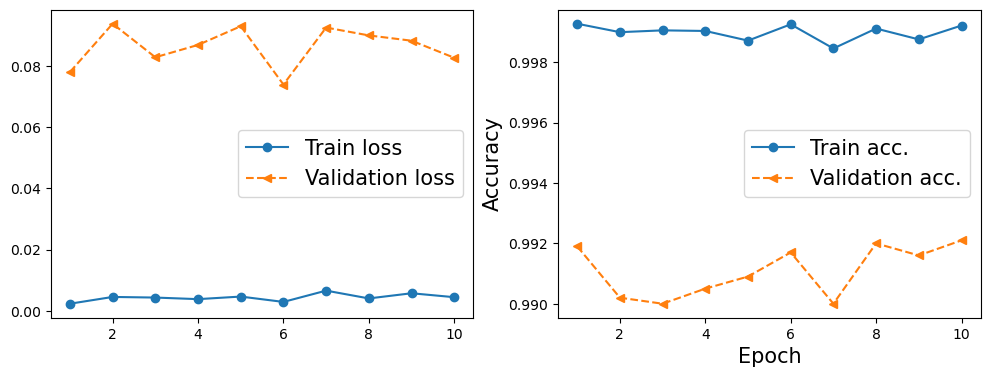

In [29]:
import matplotlib.pyplot as plt
import numpy as np

#set up x-axis
x = np.arange(len(hist[0])) + 1

#set up plots
fig = plt.figure(figsize=(12, 4))

#create plot of training and validation loss
ax = fig.add_subplot(1, 2, 1)
ax.plot(x, hist[0], '-o', label='Train loss')
ax.plot(x, hist[1], '--<', label='Validation loss')
ax.legend(fontsize=15)

#create plot of training and validation accuracy
ax = fig.add_subplot(1, 2, 2)
ax.plot(x, hist[2], '-o', label='Train acc.')
ax.plot(x, hist[3], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

plt.show()

From the learning curves above, we see that the model consistently overfits slightly to the training set. However, the validation accuracy is right around $99\%$ after only $10$ epochs, which is much higher than we were able to achieve with a neural network consisting solely of fully-connected layers.

Now, we see how the model performs on the test set.

In [32]:
#evaluate model's performance on test set
pred = model(mnist_test.data.unsqueeze(1) / 255.)
is_acc = (torch.argmax(pred, dim=1) == mnist_test.targets).float()
print(f'Test accuracy: {is_acc.mean():.4f}')

Test accuracy: 0.9929


The CNN achieved a classification accuracy of $99.29\%$ on the test set, which is extremely good and significantly better than the $97.18\%$ achieved by the neural network without any convolutional layers.

We now visualize some of the digits which were classified by the CNN to see if they appear to be correct.

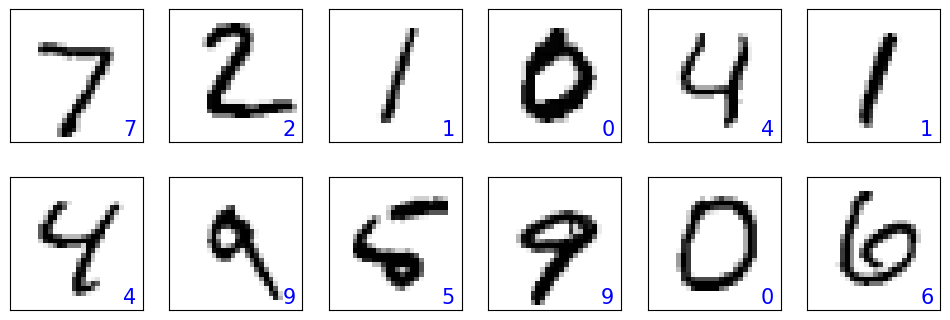

In [49]:
fig = plt.figure(figsize=(12, 4)) 
for i in range(12):
    ax = fig.add_subplot(2, 6, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    img = mnist_test[i][0][0, :, :]
    pred = model(img.unsqueeze(0).unsqueeze(1))
    y_pred = torch.argmax(pred)
    ax.imshow(img, cmap='gray_r')
    ax.text(0.9, 0.1, y_pred.item(),
            size=15, color='blue',
            horizontalalignment='center',
            verticalalignment='center',
            transform=ax.transAxes)

plt.show()